In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

import torch, torchvision
from torchvision.transforms import Compose, Normalize
from torchmetrics.classification import MulticlassAccuracy

In [14]:
data = {}
with np.load('data/octmnist.npz') as temp_data:
    for file_name in temp_data.files:
        if 'images' in file_name:
            if 'train' in file_name:
                data[file_name] = torch.from_numpy(temp_data[file_name][:20000]).float()
            elif 'test' in file_name:
                data[file_name] = torch.from_numpy(temp_data[file_name][:2000]).float()
            else:
                data[file_name] = torch.from_numpy(temp_data[file_name]).float()
        else:
            data[file_name] = torch.from_numpy(temp_data[file_name])

In [15]:
# Calculating Mean and Standard deviation
mean_set = data['train_images'].view([len(data['train_images']),-1]).mean(1).sum(0)/len(data['train_images'])
std_set = data['train_images'].view([len(data['train_images']),-1]).std(1).sum(0)/len(data['train_images'])

print('The Mean we use to normalize the data:{0}'.format(mean_set))
print('The Standard Deviation we use to normalize the data:{0}'.format(std_set))

The Mean we use to normalize the data:48.08446502685547
The Standard Deviation we use to normalize the data:43.16010665893555


### Data Loading

In [16]:
transform = Compose([
    Normalize(mean=[mean_set], std=[std_set])
])

In [17]:
# Standardization of images
data['train_images'] = transform(data['train_images'])
data['val_images'] = transform(data['val_images'])
data['test_images'] = transform(data['test_images'])


data['train_images'] = data['train_images'].unsqueeze(1)
data['val_images'] = data['val_images'].unsqueeze(1)
data['test_images'] = data['test_images'].unsqueeze(1)

data['train_labels'] = data['train_labels'].squeeze()
data['val_labels'] = data['val_labels'].squeeze()
data['test_labels'] = data['test_labels'].squeeze()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The encoded labels of the images are tensor([0, 3, 3, 3], dtype=torch.uint8):


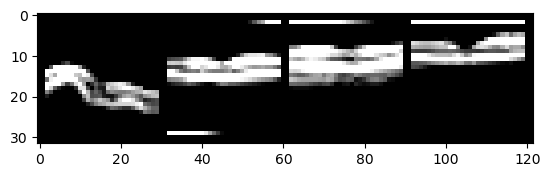

In [18]:
def matplotlib_imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images = data['train_images'][:4]
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid)
print('The encoded labels of the images are {0}:'.format(data['train_labels'][:4]))

In [19]:
class Image_Dataset(torch.utils.data.Dataset):
    def __init__(self: 'Image_Dataset', images: torch.Tensor, labels: torch.Tensor) -> None:
        """To initialize the Dataset

        Args:
            images (torch.Tensor): Image Tensor
            labels (torch.Tensor): Label Tensor
        """
        self.images = images
        self.labels = labels
    
    def __len__(self: 'Image_Dataset') -> int:
        """ Count number of images in the dataset.
        
        Returns:
            int: Returns the count of the images
        """
        return len(self.images)
    
    def __getitem__(self: 'Image_Dataset', index: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Function to get image and its lablel given index

        Args:
            index (int): index of the image we need to get

        Returns:
            tuple[torch.Tensor, torch.Tensor]: Returns single image and its label as tuple
        """
        return self.images[index], self.labels[index] 

In [20]:
train_dataset = Image_Dataset(data['train_images'], data['train_labels'])
val_dataset = Image_Dataset(data['val_images'], data['val_labels'])
test_dataset = Image_Dataset(data['test_images'], data['test_labels'])

In [21]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [22]:
if torch.backends.mps.is_available():
    DEVICE = torch.device(device='mps')
elif torch.cuda.is_available():
    DEVICE = torch.device(device='cuda')
else:
    DEVICE = torch.device(device='cpu')


### Learning Loops

In [23]:
loss_criteria = torch.nn.CrossEntropyLoss()
multiclass_accuracy  = MulticlassAccuracy(num_classes=len(data['train_labels'].unique())).to(device=DEVICE)

In [24]:
def one_epoch_train(model: torch.nn.Module, data_loader_train: torch.utils.data.DataLoader, 
                    loss_criterion: torch.nn, optim_alog: torch.optim) -> tuple:
    """Function that trains the model for one epoch.

    Args:
        model (torch.nn.Module): Pytorch model we want to train.
        data_loader_train (torch.utils.data.DataLoader): Pytorch dataloader that carries training data.
        loss_criterion (torch.nn): Pytorch loss criteria on which we calculate loss.
        optim_alog (torch.optim): Opimiztion algoritham that we use to update model weights.

    Returns:
        tuple: Tuple carrying Train loss and accuracy
    """
    batch_loss_train = []
    batch_accuracy_train = []
    batch_counter = 0
    for inputs, labels in data_loader_train:
        inputs = inputs.to(device=DEVICE)
        labels = labels.to(device=DEVICE)
        
        
        # Enabling model training.
        model.train(True)
        
        
        #Setting gradients to zero to prevent gradient accumulation.
        optim_alog.zero_grad()
        
        # Forward pass.
        y_pred_prob = model(inputs)
        loss = loss_criterion(y_pred_prob, labels)
        
        batch_loss_train.append(loss.item())
        
        # Back Propagation
        loss.backward()
        
        # Updating weights
        optim_alog.step()
        
        # Calculating training accuracy.
        with torch.inference_mode():
            accuracy = multiclass_accuracy(y_pred_prob, labels)
            batch_accuracy_train.append(accuracy.item())
        batch_counter += 1
        
        del(inputs)
        del(labels)
        
    return sum(batch_loss_train)/batch_counter, sum(batch_accuracy_train)/batch_counter

In [25]:
def inference(model: torch.nn.Module, data_loader_val: torch.utils.data.DataLoader, loss_criterion: torch.nn) -> tuple:
    """Function that calculates test accuracy

    Args:
        model (torch.nn.Module): Pytorch model we want to make inference on.
        data_loader_val (torch.utils.data.DataLoader): Pytorch dataloader that carries validation data.
        loss_criterion (torch.nn): Pytorch loss criteria on which we calculate loss.

    Returns:
        tuple: Tuple carrying Test loss and accuracy
    """
    
    batch_loss_train = []
    batch_accuracy_train = []
    batch_counter = 0
    
    for inputs, labels in data_loader_val:
        inputs = inputs.to(device=DEVICE)
        labels = labels.to(device=DEVICE)
        
        # Disabiling model training.
        model.train(False)
        
        with torch.inference_mode():
            # Forward Pass
            y_pred_prob = model(inputs)
            
            # Calculating Loss
            loss = loss_criterion(y_pred_prob, labels)
            batch_loss_train.append(loss.item())
            
            # Calculating Accuracy
            accuracy = multiclass_accuracy(y_pred_prob, labels)
            batch_accuracy_train.append(accuracy.item())
            
        batch_counter += 1
        
        del inputs
        del labels
    
    return sum(batch_loss_train)/batch_counter, sum(batch_accuracy_train)/batch_counter
        

In [26]:
def training_loop(model: torch.nn.Module, data_loader_train: torch.utils.data.DataLoader, data_loader_val: torch.utils.data.DataLoader, 
                  epochs:int, loss_criterion: torch.nn, optim_alog: torch.optim)-> dict:
    """Function that trains the model for the given number of epochs

    Args:
        model (torch.nn.Module): Pytorch model we want to train.
        data_loader_train (torch.utils.data.DataLoader): Pytorch dataloader that carries training data.
        data_loader_val (torch.utils.data.DataLoader): Pytorch dataloader that carries validation data.
        epochs (int): Count of EPOCHS
        loss_criterion (torch.nn): Pytorch loss criteria on which we calculate loss.
        optim_alog (torch.optim): Opimiztion algoritham that we use to update model weights.

    Returns:
        dict: A dictionary that carries the output metrics.
    """
    
    loss_train = []
    loss_val = []
    
    accuracy_train = []
    accuracy_val = []
    
    # Loop that iterates over each EPOCH
    for epoch in range(epochs):
        
        #Train the model for one EPOCH
        epoch_loss, epoch_accuracy = one_epoch_train(model, data_loader_train, loss_criterion, optim_alog)
        loss_train.append(epoch_loss)
        accuracy_train.append(epoch_accuracy)
        
        # Caluclating Testing results
        val_loss, val_accuracy = inference(model, data_loader_val, loss_criterion)
        loss_val.append(val_loss)
        accuracy_val.append(val_accuracy)
        
        if (epoch+1)%5 == 0:
            print('For Epoch {} We Train Loss:{}, Val Loss:{}, Train Accuracy:{}, Val Accuracy:{}'.format(epoch+1, epoch_loss,
                                                                                                        val_loss,
                                                                                                        epoch_accuracy,
                                                                                                        val_accuracy))
    return {'training_loss':loss_train, 'val_loss':loss_val, 'training_accuracy':accuracy_train, 'val_accuracy':accuracy_val}
            

In [27]:
def plot_metrics(epochs: int,metrics: dict) -> None:
    """Plot the graphs of Training and Testing Accuracy and Loss across Epoches

    Args:
        epochs (int): Number of Epochs
        metrics (dict): A dictionary containing Test and Training datasets' Loss and accuracy
    """
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(list(range(epochs)), metrics['training_loss'])
    plt.plot(list(range(epochs)), metrics['val_loss'])
    plt.grid()
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation loss across epochs')
    
    plt.subplot(1,2,2)
    plt.plot(list(range(epochs)), metrics['training_accuracy'])
    plt.plot(list(range(epochs)), metrics['val_accuracy'])
    plt.grid()
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation accuracy across epochs')
    
    plt.show()

### Model Building

In [42]:
class ModifiedAlexNet(torch.nn.Module):
    
    def __init__(self: 'ModifiedAlexNet', input_size: int)-> None:
        """Function to initate the model layers

        Args:
            input_size (int): Input size of the image
        """
        super(ModifiedAlexNet,self).__init__()
    
        self.max_pool = torch.nn.MaxPool2d(kernel_size=3,stride=1)
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11)
        conv1_size = self._get_conv_output_size(input_size, self.conv1.padding[0], self.conv1.stride[0], self.conv1.kernel_size[0])
        pool1_size = self._get_conv_output_size(conv1_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.conv2 = torch.nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
        conv2_size = self._get_conv_output_size(pool1_size, self.conv2.padding[0], self.conv2.stride[0], self.conv2.kernel_size[0])
        pool2_size = self._get_conv_output_size(conv2_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.conv3 = torch.nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
        conv3_size = self._get_conv_output_size(pool2_size, self.conv3.padding[0], self.conv3.stride[0], self.conv3.kernel_size[0])
        
        self.conv4 = torch.nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        conv4_size = self._get_conv_output_size(conv3_size, self.conv4.padding[0], self.conv4.stride[0], self.conv4.kernel_size[0])
        
        self.conv5 = torch.nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        conv5_size = self._get_conv_output_size(conv4_size, self.conv5.padding[0], self.conv5.stride[0], self.conv5.kernel_size[0])
        pool3_size = self._get_conv_output_size(conv5_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.linear1 = torch.nn.Linear(in_features=self.conv5.out_channels*pool3_size*pool3_size, out_features=4096)
        self.linear2 = torch.nn.Linear(in_features=4096, out_features=4096)
        self.linear3 = torch.nn.Linear(in_features=4096, out_features=4)
        
        self.softmax = torch.nn.Softmax(dim=1)
        
    
    def _get_conv_output_size(self: 'ModifiedAlexNet', input_size: int, padding: int, stride: int, kernel_size: int) -> int:
        """Funtion that calculate the output convolution size

        Args:
            input_size (int): Size of the input
            padding (int): Padding size
            stride (int): Stride count
            kernel_size (int): Size of the Kernel

        Returns:
            int: Output convolution size.
        """
        return ((input_size+ (2* padding) - kernel_size)//stride)+1
        
    
    def forward(self: 'ModifiedAlexNet', x: torch.Tensor) -> torch.Tensor:
        """Function that performs the forward pass of the Neural Network

        Args:
            x (torch.Tensor): Input Tensor that carries that information about a batch of images

        Returns:
            torch.Tensor: Output tensor that carries the predicted probability of each class.
        """
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = self.conv3(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv4(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv5(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = torch.nn.functional.relu(x)
        
        x = self.linear2(x)
        x = torch.nn.functional.relu(x)
        
        x = self.linear3(x)
        x = self.softmax(x)
        
        return x

In [51]:
torch.manual_seed(69)
alex_net = ModifiedAlexNet(input_size=28).to(device=DEVICE)
alex_net

ModifiedAlexNet(
  (max_pool): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 96, kernel_size=(11, 11), stride=(1, 1))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=36864, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [44]:
EPOCHS = 100
optimizer = torch.optim.Adam(alex_net.parameters(), lr=3e-5)

In [45]:
output_metrics = training_loop(model = alex_net, data_loader_train = train_dataloader, data_loader_val = val_dataloader,
                               epochs = EPOCHS, loss_criterion = loss_criteria, optim_alog = optimizer)

For Epoch 5 We Train Loss:0.9685391364767909, Val Loss:0.9621608164106499, Train Accuracy:0.4713736732546895, Val Accuracy:0.47735030953511376
For Epoch 10 We Train Loss:0.9188753692105937, Val Loss:0.9098014052638613, Train Accuracy:0.5964826647275553, Val Accuracy:0.6220779338944978
For Epoch 15 We Train Loss:0.9040830403852006, Val Loss:0.9002468673880473, Train Accuracy:0.6187248021459427, Val Accuracy:0.6303431854135519
For Epoch 20 We Train Loss:0.8924077549300635, Val Loss:0.909443156381624, Train Accuracy:0.6511692286680301, Val Accuracy:0.6361662456243791
For Epoch 25 We Train Loss:0.8829945169698697, Val Loss:0.9265741169628492, Train Accuracy:0.6822122973375047, Val Accuracy:0.6588330544904973
For Epoch 30 We Train Loss:0.8761350697221847, Val Loss:0.8899281793287722, Train Accuracy:0.6982761406289122, Val Accuracy:0.6950978269267575
For Epoch 35 We Train Loss:0.8641722546979642, Val Loss:0.8856873329410159, Train Accuracy:0.7254360405781779, Val Accuracy:0.6641784623309223


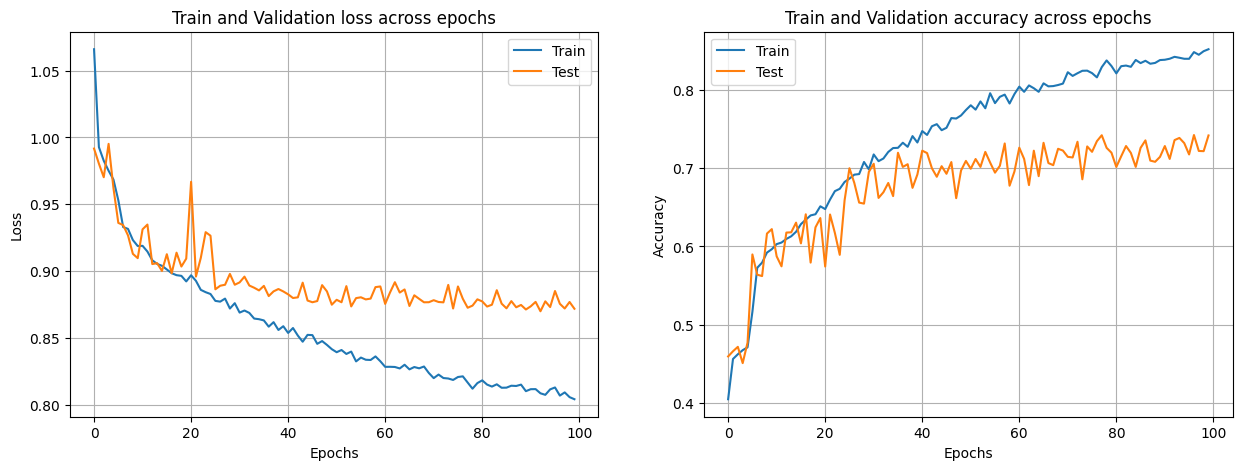

In [46]:
plot_metrics(epochs = EPOCHS,metrics = output_metrics)

In [52]:
test_loss, test_accuracy = inference(alex_net, test_dataloader, loss_criteria)

In [48]:
print('Test Accuracy is: {0}'.format(test_accuracy))

Test Accuracy is: 0.7020116224884987


In [49]:
del(alex_net)

#### Early Stopping

* The Learning curve started getting flat after 60 EPOCHS. So we will stop learning at 60 EPOCHS.

In [28]:
torch.manual_seed(69)
alex_net_es = ModifiedAlexNet(input_size=28).to(device=DEVICE)
alex_net_es

ModifiedAlexNet(
  (max_pool): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 96, kernel_size=(11, 11), stride=(1, 1))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=36864, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [29]:
EPOCHS = 60
optimizer = torch.optim.Adam(alex_net_es.parameters(), lr=3e-5)

In [30]:
output_metrics = training_loop(model = alex_net_es, data_loader_train = train_dataloader, data_loader_val = val_dataloader,
                               epochs = EPOCHS, loss_criterion = loss_criteria, optim_alog = optimizer)

For Epoch 5 We Train Loss:0.9666234152004741, Val Loss:0.9670591755250914, Train Accuracy:0.4727709620905379, Val Accuracy:0.47632217073159233
For Epoch 10 We Train Loss:0.9212748882488702, Val Loss:0.9196225181441743, Train Accuracy:0.5941480453402851, Val Accuracy:0.6047734554889983
For Epoch 15 We Train Loss:0.9028140266482442, Val Loss:0.9086907027745317, Train Accuracy:0.6163469918619711, Val Accuracy:0.6426751711199769
For Epoch 20 We Train Loss:0.891529742521219, Val Loss:0.8949808205826796, Train Accuracy:0.6542937502312584, Val Accuracy:0.646048227066839
For Epoch 25 We Train Loss:0.8877629154025556, Val Loss:0.8946263556283484, Train Accuracy:0.6686859456494975, Val Accuracy:0.6444252430513545
For Epoch 30 We Train Loss:0.8732974180779137, Val Loss:0.8880266199069741, Train Accuracy:0.6984093441559484, Val Accuracy:0.696318390798428
For Epoch 35 We Train Loss:0.8712855882157152, Val Loss:0.8822672080501343, Train Accuracy:0.705504835794528, Val Accuracy:0.6901014437541849
For

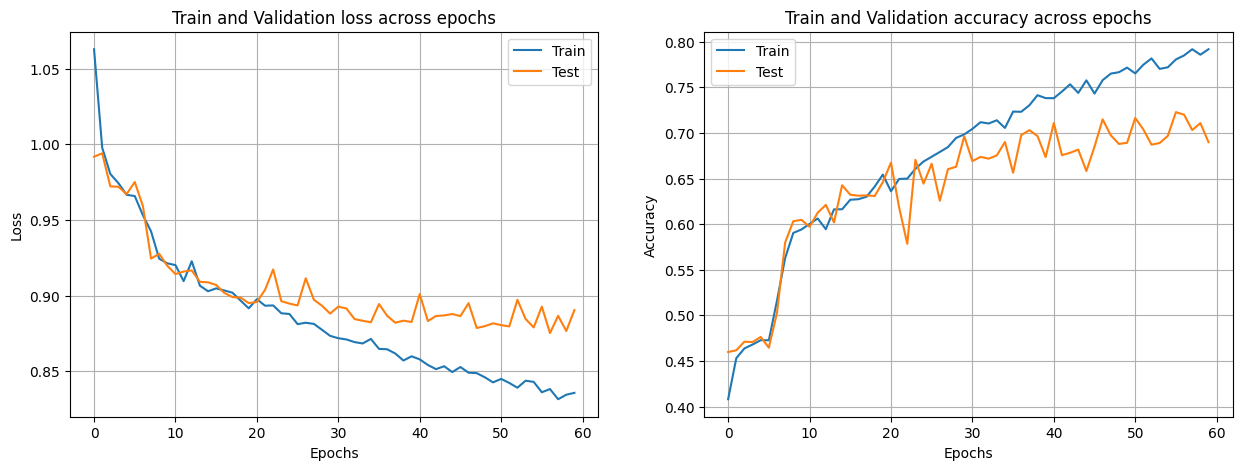

In [31]:
plot_metrics(epochs = EPOCHS,metrics = output_metrics)

In [33]:
test_loss, test_accuracy = inference(alex_net_es, test_dataloader, loss_criteria)

In [34]:
print('Test Accuracy is: {0}'.format(test_accuracy))

Test Accuracy is: 0.6764559168368578


In [35]:
del(alex_net_es)

#### L2 Regularization

In [36]:
torch.manual_seed(69)
alex_net_l2 = ModifiedAlexNet(input_size=28).to(device=DEVICE)
alex_net_l2

ModifiedAlexNet(
  (max_pool): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 96, kernel_size=(11, 11), stride=(1, 1))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=36864, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [38]:
EPOCHS = 60
optimizer = torch.optim.Adam(alex_net_l2.parameters(), lr=3e-5, weight_decay=1e-5)

In [40]:
output_metrics = training_loop(model = alex_net_l2, data_loader_train = train_dataloader, data_loader_val = val_dataloader,
                               epochs = EPOCHS, loss_criterion = loss_criteria, optim_alog = optimizer)

For Epoch 5 We Train Loss:0.9681158381909989, Val Loss:0.980509695753587, Train Accuracy:0.4713567329671817, Val Accuracy:0.4691347735645497
For Epoch 10 We Train Loss:0.9222659512449758, Val Loss:0.9193466659140798, Train Accuracy:0.5912028331154833, Val Accuracy:0.6016342962561807
For Epoch 15 We Train Loss:0.9029907089071914, Val Loss:0.913582018343045, Train Accuracy:0.6205398845025145, Val Accuracy:0.622436288711244
For Epoch 20 We Train Loss:0.8941925192793337, Val Loss:0.8934171588371637, Train Accuracy:0.6539799093057553, Val Accuracy:0.6673905202421115
For Epoch 25 We Train Loss:0.8871945961595724, Val Loss:0.8895160248145945, Train Accuracy:0.6732646953374052, Val Accuracy:0.6752157430205725
For Epoch 30 We Train Loss:0.8823292617218944, Val Loss:0.8930192631957805, Train Accuracy:0.683623815972965, Val Accuracy:0.6487210173170826
For Epoch 35 We Train Loss:0.8684864198437895, Val Loss:0.8853949028833777, Train Accuracy:0.7176219385843308, Val Accuracy:0.6801399867267384
For 

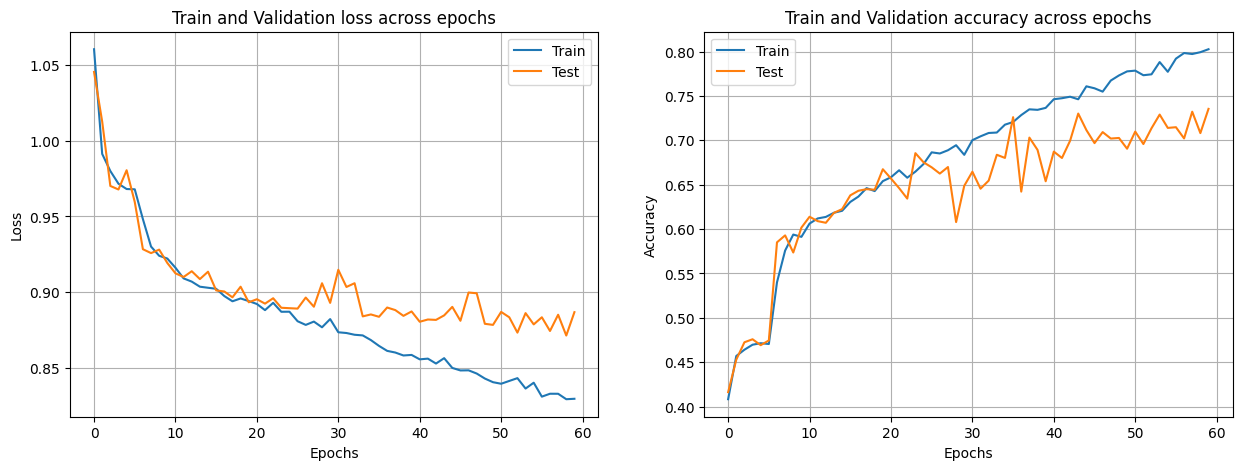

In [41]:
plot_metrics(epochs = EPOCHS,metrics = output_metrics)

In [42]:
test_loss, test_accuracy = inference(alex_net_l2, test_dataloader, loss_criteria)

In [43]:
print('Test Accuracy is: {0}'.format(test_accuracy))

Test Accuracy is: 0.6985473390668631


In [47]:
del(alex_net_l2)

#### Dropout

In [28]:
class ModifiedAlexNet(torch.nn.Module):
    
    def __init__(self: 'ModifiedAlexNet', input_size: int)-> None:
        """Function to initate the model layers

        Args:
            input_size (int): Input size of the image
        """
        super(ModifiedAlexNet,self).__init__()
    
        self.max_pool = torch.nn.MaxPool2d(kernel_size=3,stride=1)
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11)
        conv1_size = self._get_conv_output_size(input_size, self.conv1.padding[0], self.conv1.stride[0], self.conv1.kernel_size[0])
        pool1_size = self._get_conv_output_size(conv1_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.conv2 = torch.nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
        conv2_size = self._get_conv_output_size(pool1_size, self.conv2.padding[0], self.conv2.stride[0], self.conv2.kernel_size[0])
        pool2_size = self._get_conv_output_size(conv2_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.conv3 = torch.nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
        conv3_size = self._get_conv_output_size(pool2_size, self.conv3.padding[0], self.conv3.stride[0], self.conv3.kernel_size[0])
        
        self.conv4 = torch.nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        conv4_size = self._get_conv_output_size(conv3_size, self.conv4.padding[0], self.conv4.stride[0], self.conv4.kernel_size[0])
        
        self.conv5 = torch.nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        conv5_size = self._get_conv_output_size(conv4_size, self.conv5.padding[0], self.conv5.stride[0], self.conv5.kernel_size[0])
        pool3_size = self._get_conv_output_size(conv5_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.linear1 = torch.nn.Linear(in_features=self.conv5.out_channels*pool3_size*pool3_size, out_features=4096)
        self.linear2 = torch.nn.Linear(in_features=4096, out_features=4096)
        self.linear3 = torch.nn.Linear(in_features=4096, out_features=4)

        self.dropout = torch.nn.Dropout(p=0.4)
        
        self.softmax = torch.nn.Softmax(dim=1)
        
    
    def _get_conv_output_size(self: 'ModifiedAlexNet', input_size: int, padding: int, stride: int, kernel_size: int) -> int:
        """Funtion that calculate the output convolution size

        Args:
            input_size (int): Size of the input
            padding (int): Padding size
            stride (int): Stride count
            kernel_size (int): Size of the Kernel

        Returns:
            int: Output convolution size.
        """
        return ((input_size+ (2* padding) - kernel_size)//stride)+1
        
    
    def forward(self: 'ModifiedAlexNet', x: torch.Tensor) -> torch.Tensor:
        """Function that performs the forward pass of the Neural Network

        Args:
            x (torch.Tensor): Input Tensor that carries that information about a batch of images

        Returns:
            torch.Tensor: Output tensor that carries the predicted probability of each class.
        """
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = self.conv3(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv4(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv5(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        
        x = self.linear2(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        
        x = self.linear3(x)
        x = self.softmax(x)
        
        return x

In [29]:
torch.manual_seed(69)
alex_net_do = ModifiedAlexNet(input_size=28).to(device=DEVICE)
alex_net_do

ModifiedAlexNet(
  (max_pool): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 96, kernel_size=(11, 11), stride=(1, 1))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=36864, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=4, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (softmax): Softmax(dim=1)
)

In [19]:
EPOCHS = 60
optimizer = torch.optim.Adam(alex_net_do.parameters(), lr=3e-5)

In [20]:
output_metrics = training_loop(model = alex_net_do, data_loader_train = train_dataloader, data_loader_val = val_dataloader,
                               epochs = EPOCHS, loss_criterion = loss_criteria, optim_alog = optimizer)

For Epoch 5 We Train Loss:0.9727609487006459, Val Loss:0.9794523763445626, Train Accuracy:0.4685018502485257, Val Accuracy:0.46988183857768684
For Epoch 10 We Train Loss:0.9194194385038016, Val Loss:0.9158666369485996, Train Accuracy:0.5988009176886501, Val Accuracy:0.5985643992030163
For Epoch 15 We Train Loss:0.9022716959825339, Val Loss:0.9046489744059807, Train Accuracy:0.619078841262732, Val Accuracy:0.626187977801382
For Epoch 20 We Train Loss:0.8941793679810179, Val Loss:0.8994006716747903, Train Accuracy:0.6420834491999385, Val Accuracy:0.6364288017109784
For Epoch 25 We Train Loss:0.890588496439754, Val Loss:0.9025197127575719, Train Accuracy:0.6594738846008008, Val Accuracy:0.6464855920600329
For Epoch 30 We Train Loss:0.8810656674372883, Val Loss:0.9119883868898262, Train Accuracy:0.6753526575649127, Val Accuracy:0.630882460898706
For Epoch 35 We Train Loss:0.870940159875364, Val Loss:0.9157895213734787, Train Accuracy:0.7046474464023456, Val Accuracy:0.7006476999735762
For 

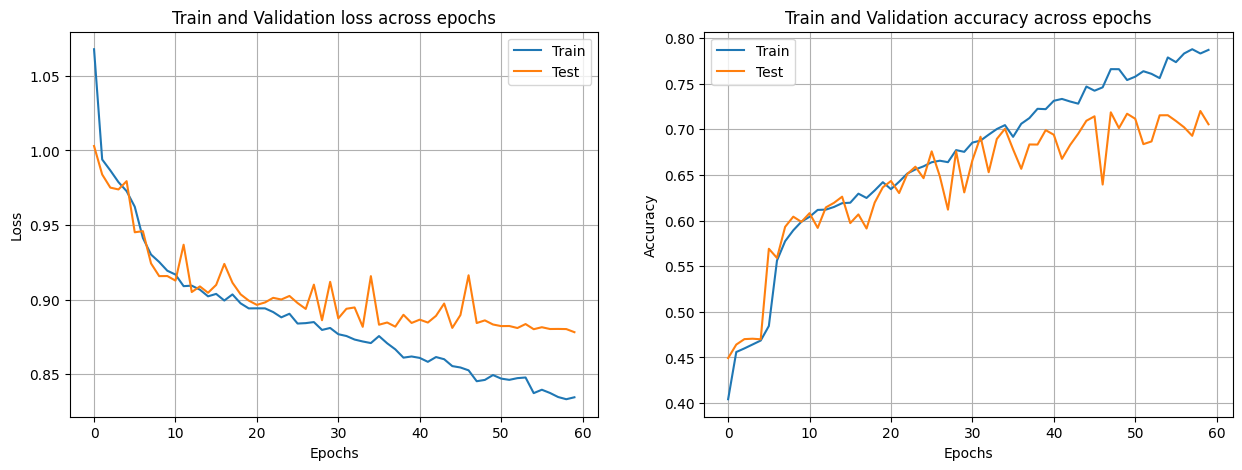

In [21]:
plot_metrics(epochs = EPOCHS,metrics = output_metrics)

In [22]:
test_loss, test_accuracy = inference(alex_net_do, test_dataloader, loss_criteria)

In [23]:
print('Test Accuracy is: {0}'.format(test_accuracy))

Test Accuracy is: 0.7138761524111032


In [24]:
torch.save(alex_net_do.state_dict(), 'sadapala_assignment1_part_4.pickle')

In [25]:
del(alex_net_do)

In [33]:
alex_net_do.load_state_dict(torch.load('models/sadapala_assignment1_part_4.pickle', map_location=DEVICE))

<All keys matched successfully>

In [34]:
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [36]:
for images, labels in test_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    alex_net_do.train(False)
    with torch.inference_mode():
        y_hat = alex_net_do(images)
    break

#### Confusion Matrix, Precision, Recall and F1 Score.

In [47]:
confusion_matrix(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy())

array([[236,  10,   2,   2],
       [ 19, 212,   6,  13],
       [115,   8,  27, 100],
       [ 12,   2,   5, 231]])

In [51]:
print("Precision (Micro):", precision_score(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy(), average='micro'))
print("Precision (Macro):", precision_score(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy(), average='macro'))
print("Precision (Weighted):", precision_score(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy(), average='weighted'))

Precision (Micro): 0.706
Precision (Macro): 0.7185560520930407
Precision (Weighted): 0.7185560520930407


In [52]:
print("Recall (Micro):", recall_score(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy(), average='micro'))
print("Recall (Macro):", recall_score(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy(), average='macro'))
print("Recall (Weighted):", recall_score(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy(), average='weighted'))

Recall (Micro): 0.706
Recall (Macro): 0.706
Recall (Weighted): 0.706


In [53]:
print("F1 Score (Micro):", f1_score(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy(), average='micro'))
print("F1 Score (Macro):", f1_score(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy(), average='macro'))
print("F1 Score (Weighted):", f1_score(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy(), average='weighted'))

F1 Score (Micro): 0.706
F1 Score (Macro): 0.6469695436542823
F1 Score (Weighted): 0.6469695436542824


### References:

* Part 4 and Part 5 Architecture and Helper Functions are based CSE 574 Machine Learning Assignment 2 by Shri Harsha Adapala Thirumala.
* Numpy: https://numpy.org/doc/stable/
* Pandas: https://pandas.pydata.org/docs/reference/index.html
* Matplotlib: https://matplotlib.org/stable/api/index.html
* Seaborn: https://seaborn.pydata.org/api.html
* PyTorch: https://pytorch.org/docs/stable/index.html
* TorchVision: https://pytorch.org/vision/stable/index.html
* TorchMetrics: https://torchmetrics.readthedocs.io/en/stable/
* AlexNet: https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf
* Earlystopping: https://www.educative.io/answers/what-is-early-stopping
